# Предсказание сердечных заболеваний.

## Введение

Целью данного проекта является прогнозирование риска сердечных заболеваний на основе информации об образе жизни пациента.
Показателем оценки является метрика *ROC-AUC*.

## Описание данных

Таблица *train.csv* содержит набор обучающих данных, в таблице *test.csv* тестовые данные, а таблица *sample_submission.csv* представляет из себя образец файла отправки.

Описание колонок не предоставлено, но из названия и данных, содержащихся в них составим описание.

Признаки:

- `id` — номер записи;
- `age` — возраст пациента;
- `gender` — пол;
- `height` — рост;
- `weight` — вес;
- `ap_hi` — нижняя граница артериального давления (АД);
- `ap_lo` — верхняя граница АД;
- `cholestirol` — уровень холестерина;
- `gluc` — глюкоза в крови;
- `smoke` — признак курящего пациента;
- `alco` — признак пациента, употребляющего алкоголь на постоянной основе;
- `active` — признак физически активного пациента.

Целевой признак:

- `cardio` - наличие риска сердечных заболеваний.

## Подготовка данных

Импорт используемых библиотек и методов

In [32]:
# импортируем библиотеки и необходимые методы из других библиотек
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import optuna
from pylab import rcParams
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

Настройка стилей и форматов вывода

In [5]:
# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# установим графическую тему для графиков и гистограмм
plt.style.use('seaborn-v0_8-darkgrid')

# настроим отображение до 25-ти колонок
pd.set_option('display.max_columns', 25)

# настроим местоположение и размер шрифта для легенды и названий графиков и гистограмм
rcParams['legend.loc'] = 'upper left'
rcParams['legend.fontsize'] = 14
rcParams['axes.titlesize'] = 16

Объявление глобальных переменных

In [6]:
# случайное состояние для создания псевдослучайных последовательностей
MY_SEED = 1123581321

Чтение данных

In [7]:
# читаем данные в датафреймы с локального ПК, а если не получится, то из интернета
train = pd.read_csv('./datasets/train 2.csv', sep=',')
test = pd.read_csv('./datasets/test 2.csv', sep=',')

# присвоим таблицам имена:
train.name = 'Обучающий датасет'
test.name = 'Тестовый датасет'

## Предобработка и исследовательский анализ данных

Общая информация

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Описание данных

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"70,000.00","49,972.42","28,851.30",0.00,"25,006.75","50,001.50","74,889.25","99,999.00"
age,"70,000.00","19,468.87","2,467.25","10,798.00","17,664.00","19,703.00","21,327.00","23,713.00"
gender,"70,000.00",1.35,0.48,1.00,1.00,1.00,2.00,2.00
height,"70,000.00",164.36,8.21,55.00,159.00,165.00,170.00,250.00
weight,"70,000.00",74.21,14.40,10.00,65.00,72.00,82.00,200.00
ap_hi,"70,000.00",128.82,154.01,-150.00,120.00,120.00,140.00,"16,020.00"
ap_lo,"70,000.00",96.63,188.47,-70.00,80.00,80.00,90.00,"11,000.00"
cholesterol,"70,000.00",1.37,0.68,1.00,1.00,1.00,2.00,3.00
gluc,"70,000.00",1.23,0.57,1.00,1.00,1.00,1.00,3.00
smoke,"70,000.00",0.09,0.28,0.00,0.00,0.00,0.00,1.00


Пример данных (5 случайных строк)

In [10]:
train.sample(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
55051,78531,19040,1,158,88.00,120,70,3,1,0,0,0,0
8922,12720,15343,1,165,65.00,130,80,1,1,0,0,1,1
17062,24378,15314,2,180,120.00,120,80,2,2,1,1,1,1
29868,42705,16786,1,178,97.00,120,80,1,1,0,1,1,0
28515,40773,23356,1,175,70.00,120,80,1,1,0,0,1,1


Информация о наличие явных дубликатов данных

In [11]:
print('Количество дубликатов в данных:', train.duplicated().sum())

Количество дубликатов в данных: 0


Размерность датафрейма

In [12]:
print(f'Количество столбцов: {train.shape[1]}, число записей: {train.shape[0]}')

Количество столбцов: 13, число записей: 70000


Названия столбцов корректные, пропусков и явных дубликатов в данных нет.
Столбец `id` не содержит полезной информации, удалим его.
Целевым признаком является столбец `cardio`.

In [13]:
train.drop('id', axis=1, inplace=True)

После удаление столбца возможно появление дубликатов данных, проверим ещё раз.

In [14]:
print('Количество дубликатов в данных:', train.duplicated().sum())

Количество дубликатов в данных: 24


Обнаружилось небольшое количество дубликатов в данных. Точную причину их появления в нашем случае выяснить не получится. Это могут быть как технические причины, так и простое совпадение. В любом случае, для построения моделей такие записи будут мешать, особенно, при использовании кросс-валидации. Удалим эти записи.

In [15]:
# удалим из обучающей выборки явные дубликаты данных
train.drop_duplicates(inplace=True)

Рассмотрим тепловую карту корреляции признаков.

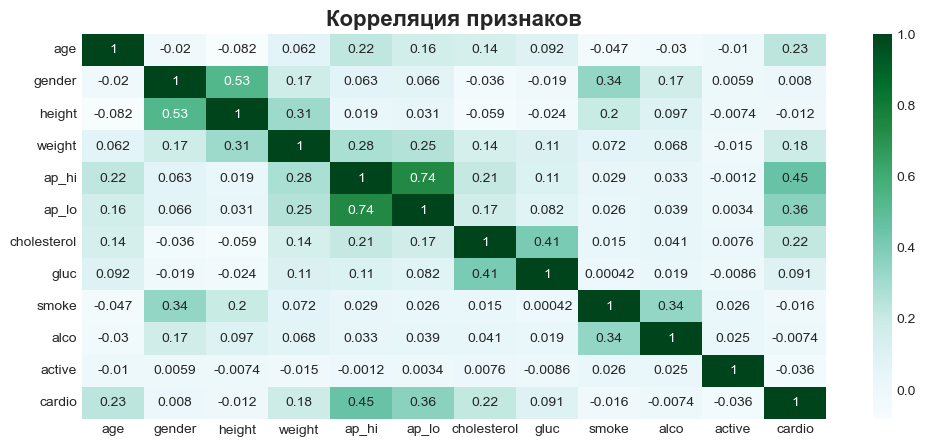

In [16]:
plt.figure(figsize=(12, 5))
plt.title('Корреляция признаков', weight = 'bold')
sns.heatmap(train.corr(method='spearman'), annot = True, cmap='BuGn')
plt.show()

Прослеживается явная зависимость нижней и верхней границ кровяного давления.
Признаки в наших данных можно разделить на три типа:
- количественные;
- категориальные;
- бинарные.

Исследуем отдельно каждый тип.

### Исследование количественных признаков

Столбец `age` (возраст) имеет странный формат, скорее всего, он выражен в днях. Для модели это не критично, но для более определения реальности некоторых значений, пересчитаем эти данные в года.

In [17]:
# переведем возраст в года
train['age'] = round(train['age'] / 365)

Напишем функцию, которая будет отображать плотность распределения и ящик с усами для каждого количественного признака.

In [18]:
# -----------------------------------------------------------------------------------------
# функция вывода информации для количественных значений:
# - плотность распределения;
# - boxplot.
#
# input:    df - датафрейм, по которому выводим информацию;
#           col_title - название признака;
#           num_bins - количество корзин для гистограммы.
# output:   None
# -----------------------------------------------------------------------------------------

def show_num_features(df, col_title, num_bins):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].set_title(col_title + '. Плотность распределения', fontsize=16)
    axes[0].set_ylabel('плотность')
    axes[1].set_title(col_title + '. Ящик с усами', fontsize=16)
    axes[1].set_ylabel('значения')
    sns.histplot(df, bins=num_bins, ax=axes[0])
    sns.boxplot(data=df, ax=axes[1])
    plt.show()
    return

Создадим список столбцов с количественным признаком и в цикле с помощью функции `show_num_features` выведем для каждого гистограмму распределения плотности значений и ящик с усами.

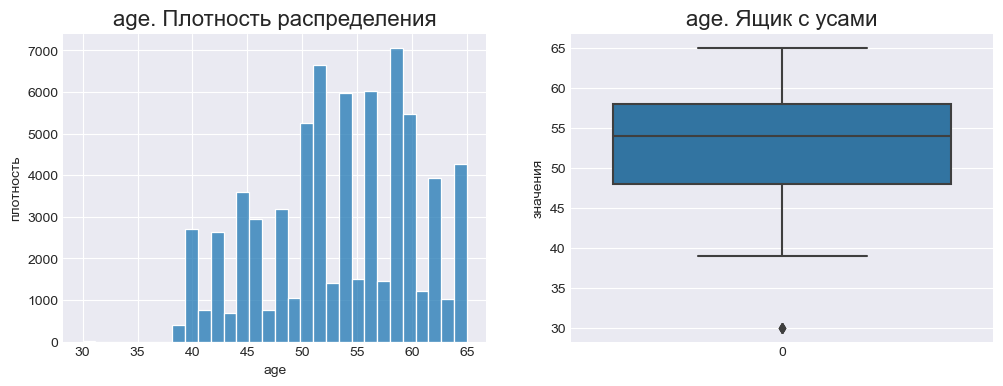

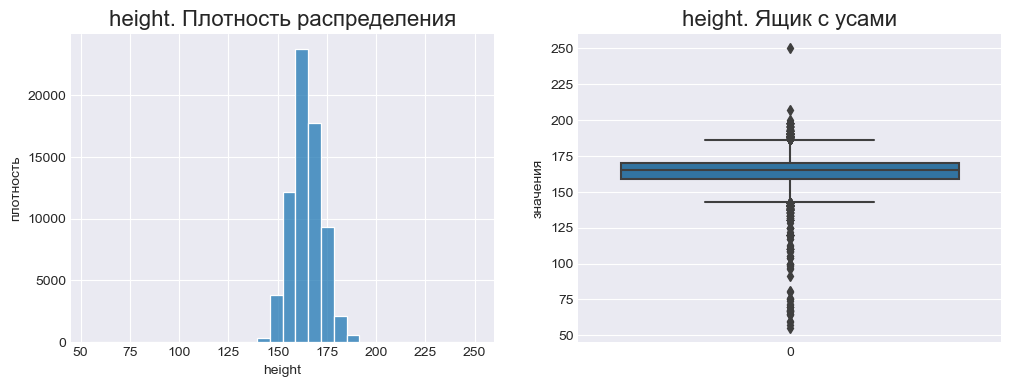

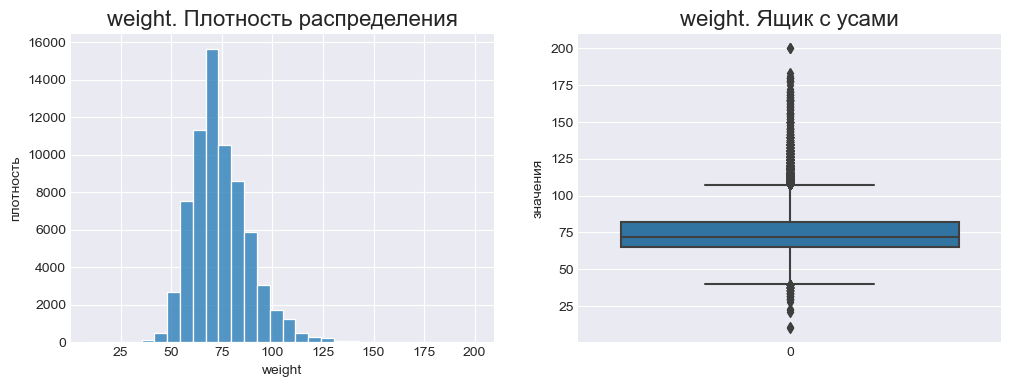

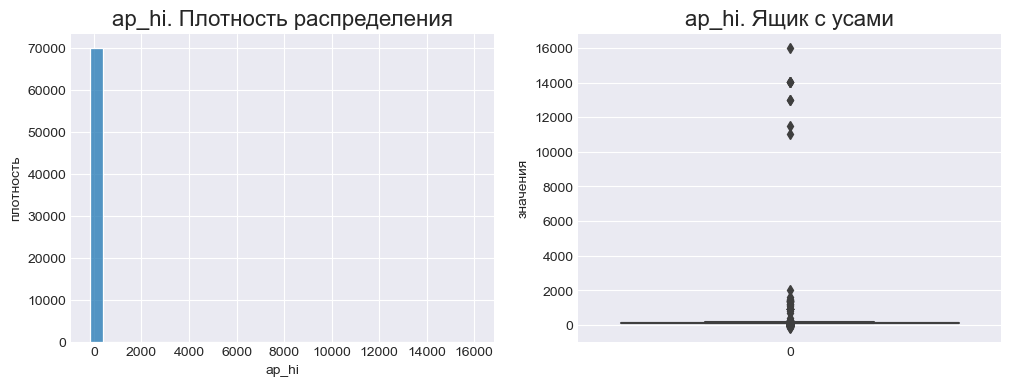

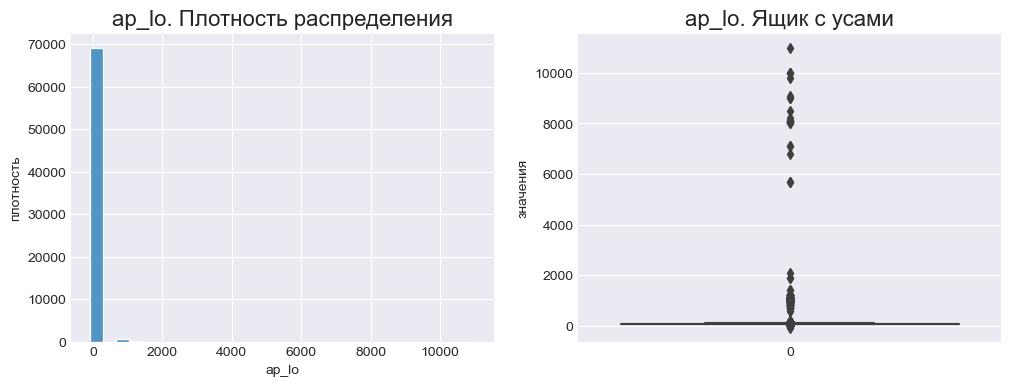

In [19]:
num_columns_lst = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

for column in train[num_columns_lst]:
    show_num_features(train[column], column, num_bins=30)

С возрастом всё более-менее хорошо. По весу пока не будем ничего корректировать, в дальнейшем рассчитаем индекс массы тела (ИМТ) и тогда определим критические значения. По давлению есть отрицательные значения и явно завышенные, предположим, что отрицательные значения появились из-за того, что кто-то случайно поставил "минус", для исправления этой ошибки возьмём модуль для всех значений. Значения, больше 999 могли появиться из-за лишнего нуля в конце, разделим эти значения на 10, а значения больше 9999 разделим на 100.

In [20]:
train['ap_hi'] = abs(train['ap_hi'])
train['ap_lo'] = abs(train['ap_lo'])
train.loc[train['ap_hi'] > 9999, 'ap_hi'] = train['ap_hi'] / 100
train.loc[train['ap_lo'] > 9999, 'ap_lo'] = train['ap_lo'] / 100
train.loc[train['ap_hi'] > 999, 'ap_hi'] = train['ap_hi'] / 10
train.loc[train['ap_lo'] > 999, 'ap_lo'] = train['ap_lo'] / 10

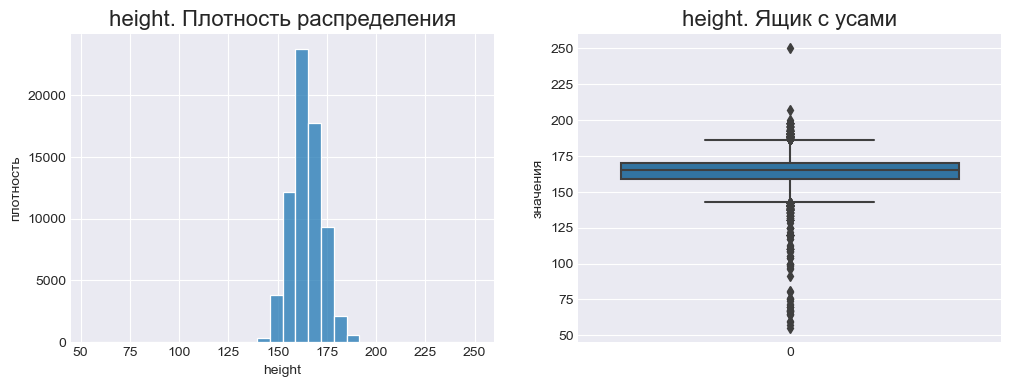

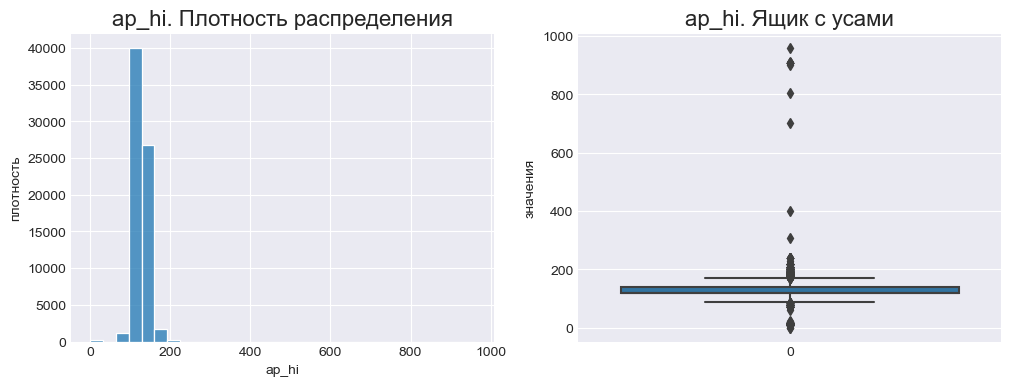

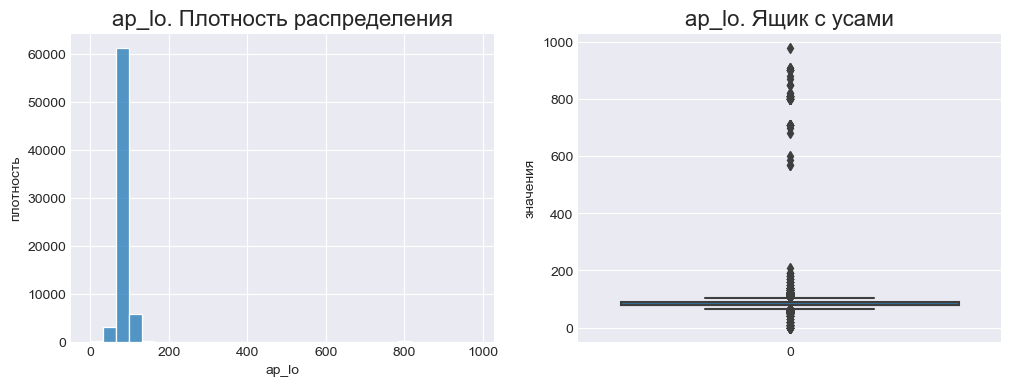

In [21]:
num_columns_lst = ['height', 'ap_hi', 'ap_lo']

for column in train[num_columns_lst]:
    show_num_features(train[column], column, num_bins=30)

Теперь данные выглядят более правдоподобно.
Рассчитаем индекс массы тела по формуле $ ИМТ = {m\over h^2} $ Удалим теперь уже ненужные столбцы с весом и ростом, составим список из названий количественных колонок.

In [22]:
train['bmi'] = train['weight'] / (train['height'] / 100)**2
train.drop('weight', axis=1, inplace=True)
train.drop('height', axis=1, inplace=True)
num_columns_lst = ['age', 'bmi', 'ap_hi', 'ap_lo']

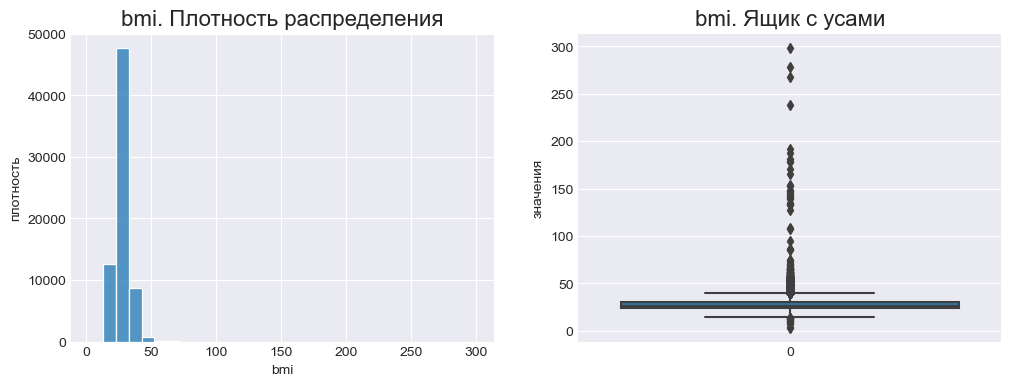

In [23]:
show_num_features(train['bmi'], 'bmi', num_bins=30)

Количественные признаки обработаны.

### Изучение категориальных признаков

Рассмотрим какие есть категории и составим список названий категориальных признаков.

In [24]:
display(train['cholesterol'].value_counts().to_frame())
display(train['gluc'].value_counts().to_frame())
cat_columns_lst = ['cholesterol', 'gluc']

,cholesterol
1,52361
2,9549
3,8066


,gluc
1,59455
3,5331
2,5190


### Исследование бинарных признаков

В бинарных признаках закодируем пол нулями и единицами и приведём все признаки к типу `'bool'`.

In [25]:
# закодируем пол
train.loc[train['gender'] == 2, 'gender'] = 0

# приведем двоичные данные в соответствие их типу
lst = ['gender', 'smoke', 'alco', 'active']
train[lst] = train[lst].astype('bool')

Проверим данные на наличие явных дубликатов.

In [26]:
print('Количество дубликатов в данных:', train.duplicated().sum())

Количество дубликатов в данных: 3798


Удалим дубликаты.

In [27]:
train.drop_duplicates(inplace=True)

Создадим признаки для моделей.

In [28]:
# создадим признаки для моделей
features_train = train.drop('cardio', axis=1)

# выделим целевой признак
target_train = train['cardio']

## Разработка моделей ML

### *CatBoost + RobustScaler + OrdinalEncoder*

In [29]:
# подготовим кросс-валидацию на 5-х выборках
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=MY_SEED)

In [30]:
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(RobustScaler()), num_columns_lst),
    ('cat', make_pipeline(OrdinalEncoder()), cat_columns_lst)]))
# классификатор модели
step_CBC = ('CBC', CatBoostClassifier(random_state=MY_SEED, verbose=False))

# зададим последовательность обработки
pipeline_CBC = Pipeline(steps=[step_FPP, step_CBC])

param_distrs = {'CBC__learning_rate': optuna.distributions.FloatDistribution(0.0001, 60),
                'CBC__min_data_in_leaf': optuna.distributions.IntDistribution(1, 102),
                'CBC__iterations': optuna.distributions.IntDistribution(500, 2000, 50),
                'CBC__subsample': optuna.distributions.FloatDistribution(0.4, 0.9),
                }

opt_search = optuna.integration.OptunaSearchCV(pipeline_CBC, param_distrs, cv=kf, random_state=MY_SEED,
                                               n_trials=1000, scoring='roc_auc', timeout=5000)

# зафитим модель и замерим время моделирования
start_time = time.time()
opt_search.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'roc_auc = {opt_search.best_score_:.4f}')

/var/folders/71/60907wwd3t501jq05yfrh2100000gn/T/ipykernel_23629/969340423.py:18: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  opt_search = optuna.integration.OptunaSearchCV(pipeline_CBC, param_distrs, cv=kf, random_state=MY_SEED,
[I 2023-03-07 21:55:37,864] A new study created in memory with name: no-name-c3cdae13-84a3-4a9f-8d37-9fa4bf341759
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
Training has stopped (degenerate solution on iteration 4, probably too small l2-regularization, try to increase it)
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning ra

roc_auc = 0.7986


### *RandomForest + StandardScaler + OrdinalEncoder*

In [33]:
# зададим диапазоны гиперпараметров для подбора
param_distributions = {'RFC__n_estimators': range(50, 325, 25),
                       'RFC__max_depth': range(1, 18, 1),
                       'RFC__min_samples_split': range(2, 52, 5),
                       'RFC__min_samples_leaf': range(2, 52, 5)}

# подготовим кросс-валидацию на 3-х выборках
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=MY_SEED)
# создадим шаги для обработки
# масштабирование и категоризация признаков (FPP - features pre-processing)
step_FPP = ('FPP', ColumnTransformer([
    ('num', make_pipeline(StandardScaler()), num_columns_lst),
    ('cat', make_pipeline(OrdinalEncoder()), cat_columns_lst)]))

# классификатор модели
step_RFC = ('RFC', RandomForestClassifier(random_state=MY_SEED))

# зададим последовательность обработки
pipeline_RFC = Pipeline(steps=[step_FPP, step_RFC])

# создадим объект модели
rs_imba = RandomizedSearchCV(pipeline_RFC, param_distributions, n_iter=150, cv=kf, verbose=1,
                             n_jobs=-1, scoring='roc_auc', return_train_score=True, random_state=MY_SEED)

# зафитим модель и замерим время моделирования
start_time = time.time()
rs_imba.fit(features_train, target_train)
run_time = (time.time() - start_time) / 60

# выведем значение F1-меры
print(f'roc_auc = {rs_imba.best_score_:.4f}')

Fitting 3 folds for each of 150 candidates, totalling 450 fits
roc_auc = 0.7975


В результате обучения лучшие показатели метрики ROC-AUC у модели *'CatBoost + RobustScaler + OrdinalEncoder'*, ёё и будем использовать для предскания вероятности развития сердечно-сосудистых заболеваний на тестовых данных.

## Тестирование модели

Подготовим тестовый датасет для тестирования.

In [34]:
test['ap_hi'] = abs(test['ap_hi'])
test['ap_lo'] = abs(test['ap_lo'])
test.loc[test['ap_hi'] > 9999, 'ap_hi'] = test['ap_hi'] / 100
test.loc[test['ap_lo'] > 9999, 'ap_lo'] = test['ap_lo'] / 100
test.loc[test['ap_hi'] > 999, 'ap_hi'] = test['ap_hi'] / 10
test.loc[test['ap_lo'] > 999, 'ap_lo'] = test['ap_lo'] / 10
test['bmi'] = test['weight'] / (test['height'] / 100)**2
test.drop('weight', axis=1, inplace=True)
test.drop('height', axis=1, inplace=True)

# закодируем пол
test.loc[test['gender'] == 2, 'gender'] = 0
test[lst] = test[lst].astype('bool')

Получим предсказание и оценки вероятностей положительного исхода на тестовых данных.

In [35]:
# подготовим датафрейм для отправки данных на kaggle
sumple_submission = pd.DataFrame(test['id'])
test.drop('id', axis=1, inplace=True)

# получим предсказание модели на тестовой выборке
predicted_test = opt_search.best_estimator_.predict(test)
sumple_submission['cardio'] = predicted_test

# получим оценки вероятности положительного исхода
y_pred = opt_search.best_estimator_.predict_proba(test)[:, 1]

# запишем полученные вероятности
sumple_submission['cardio'] = y_pred

Запишем получившиеся данные в файл для отправки на платформу *kaggle*.

In [36]:
# запишем файл для отправки
sumple_submission.to_csv('./datasets/sumple_submission.csv', index=False)

## Продакшн модели

In [37]:
from pickle import dump

In [42]:
# сохраняем модель в двоичном виде
with open('./models/model.pcl', 'wb') as fid:
    dump(opt_search.best_estimator_, fid)

In [ ]:
# import pandas_profiling
# train.profile_report(title='Pandas Profiling Report', progress_bar=True).to_file('train.html')